In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data

import seaborn as sns
import plotly.graph_objects as go

import statsmodels.api as sm
import statsmodels.formula.api as smf

import networkx as nx

/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch_geometric
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go

from typing import Optional, Iterable

from src.visualization.display_graph import convert_torch_to_networkx_graph, draw_torch_graph
import src.processing.preprocessing as preprocessing
import src.graph_analysis.shortest_paths as gsp

import src.data_handler as data_handler


from src.processing.raw_data_cleaning import prepare_graph_for_participant
from src.models.model_pipeline import ModelPipeline
from src.models.baseline_models import SimpleConvModel
from src.models.nn.gnn_layers import MyGATConv
from src.models.nn.ML_frameworks import GNNFramework

In [4]:
word_to_embeddings = pd.read_csv("data/processed/node_data/word_to_embeddings_MPNet.csv",index_col=0)
word_to_embeddings

,Art gallery,Autobiography book,Baking cookies,Board games,Book club,Bread making,Brunch,Chat online,Cinema,Clothes shopping,...,Science non-fiction book,Spin class,Sports video games,Spotify playlist,Stand up comedy night,Theater show,Trivia night,True crime TV series,Walk in the park,YouTube videos
0,0.000441,0.020321,-0.020057,0.007999,0.002294,-0.011104,-0.075563,0.010652,-0.008659,0.012313,...,0.009056,-0.044112,-0.056991,0.001361,-0.001788,-0.029465,0.014876,0.037559,-0.009760,-0.004024
1,0.045686,0.102725,-0.024937,-0.031160,0.031765,-0.068007,-0.030074,-0.025831,0.031551,0.011559,...,0.000556,0.003495,-0.016453,-0.035871,0.035412,-0.003836,-0.015835,0.037163,0.043572,0.023029
2,-0.022454,-0.002505,-0.007034,-0.049151,0.006674,-0.026462,-0.005008,-0.001276,0.003838,-0.003021,...,0.025813,0.024716,-0.041171,-0.030161,0.012084,-0.007466,0.026789,0.022725,0.000901,0.019776
3,0.011243,-0.029869,0.013753,0.021141,-0.021081,-0.002147,-0.048156,-0.022553,-0.040573,0.007096,...,-0.034126,0.049716,0.014541,-0.011522,-0.033125,0.036850,-0.009766,-0.011547,-0.015778,-0.030209
4,-0.040381,-0.043690,-0.034387,-0.023805,-0.001275,-0.041257,-0.061852,-0.032978,-0.005970,0.027096,...,-0.027805,0.037900,0.026531,0.042019,-0.003717,-0.021979,-0.027301,-0.070911,-0.028107,0.012786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-0.071475,-0.005522,-0.011470,0.008280,-0.000616,-0.064646,0.041061,0.053122,-0.008299,0.043185,...,0.036495,0.073921,-0.021071,-0.006017,0.008455,0.004161,-0.026414,-0.068769,0.055951,-0.017057
764,-0.017353,-0.048217,-0.004639,-0.007991,-0.033453,-0.007899,-0.029645,0.002682,0.015221,-0.009982,...,-0.020007,-0.033269,0.027047,0.021769,-0.022030,-0.032322,-0.012814,-0.025039,-0.059551,-0.009974
765,0.025245,-0.013924,-0.012408,0.028306,0.032427,-0.027998,0.005302,0.035315,0.036678,0.024726,...,0.055781,0.019996,0.017567,0.017137,-0.003025,0.009309,0.046144,0.020725,0.031398,0.005532
766,-0.009092,0.008886,-0.029330,0.001636,-0.020977,-0.051137,-0.007852,-0.007571,-0.018555,-0.021302,...,-0.003627,-0.052674,-0.001494,0.014288,0.053107,0.034416,-0.000699,-0.004815,0.004075,0.023214


In [5]:
def compute_vector_distance(A,B,ord=1):
    """
    res[i,j] = ||A[i,:] - B[j,:]||_ord
    """
    assert len(A.shape) == 2, A.shape
    assert len(B.shape) == 2, B.shape
    assert A.shape[1] == B.shape[1], (A.shape, B.shape)
    m, d = A.shape
    n, d = B.shape

    aug_A = np.einsum("mdj,ndj->mnd", A[...,np.newaxis],np.ones((n,d,1)))
    aug_B = np.einsum("ndj,mdj->mnd", B[...,np.newaxis],np.ones((m,d,1)))
    res = np.power(np.sum(np.power(np.abs(aug_A - aug_B),ord),axis = -1),1/ord)
    return res

compute_vector_distance(np.array([[0,1],[1,2]]),np.array([[0,3]]),ord=2)


def merge_graphs_edges(edge_index_0:np.ndarray,edge_index_1:np.ndarray,edge_attr_0:pd.DataFrame|None = None,edge_attr_1:pd.DataFrame|None = None):
    res_edge_index = copy.deepcopy(edge_index_0)
    edge_index_dist = compute_vector_distance(res_edge_index.T,edge_index_1.T)
    edge_index_null_dist = np.isclose(edge_index_dist,0)
    edge_index_null_dist = np.sum(edge_index_null_dist,axis=0)
    edge_index_id_no_rep = np.where(edge_index_null_dist==0)[0]
    res_edge_index = np.concatenate([res_edge_index,edge_index_1[:,edge_index_id_no_rep]],axis=1)

    if not(edge_attr_0 is None or edge_attr_1 is None):
        assert len(set(edge_attr_0.columns.tolist()).intersection(set(edge_attr_1.columns.tolist()))) == len(edge_attr_0.columns.tolist()), (edge_attr_0.columns,edge_attr_1.columns)
        res_edge_attr = pd.concat([edge_attr_0,edge_attr_1.iloc[edge_index_id_no_rep]],axis=0).reset_index(drop = True)
    else:
        res_edge_attr = None
    
    return res_edge_index, res_edge_attr

def add_edge_L2_dist_to_graph(participant_graph, translator_word_to_index, word_to_embeddings = word_to_embeddings):

    translator_index_to_word_emb = {v:np.array(word_to_embeddings[k]) for k,v in translator_word_to_index.items()} # will have to add .values when loading 
    
    edge_L2_dist = []
    for edge_i in range(participant_graph.edge_index.size(1)):
        sender_id,receiver_id = participant_graph.edge_index[:,edge_i]
        sender_id,receiver_id = int(sender_id), int(receiver_id)
        L2_dist = np.linalg.norm(translator_index_to_word_emb[receiver_id] - translator_index_to_word_emb[sender_id])
        edge_L2_dist.append([L2_dist])

    edge_L2_dist = torch.Tensor(edge_L2_dist)
    participant_graph.edge_attr = torch.concat([participant_graph.edge_attr,edge_L2_dist],dim=1)
    participant_graph.edge_attr_names.append("L2_dist")
    return participant_graph


def shortest_paths_from_cluster(edge_index:np.array,
                                edge_weight:Iterable,
                                cluster:np.ndarray[bool],
                                exclude_itself:bool=True):
    _cluster = copy.copy(cluster)
    num_nodes = len(_cluster)

    node_ids_cluster = np.where(_cluster)[0]

    node_ids_not_cluster = np.where(~_cluster)[0]
    node_to_browse = node_ids_not_cluster
    if not(exclude_itself):
        node_to_browse = np.arange(num_nodes)
    
    node_to_dist_from_cluster, node_to_shortest_path_from_cluster = np.inf*np.ones(num_nodes), dict()

    for i in node_ids_cluster:
        dist_from_i, shortest_path_from_i = gsp.shortest_path_djikstra(node_start=i,
                                                                           edge_index=edge_index,
                                                                           edge_weight=edge_weight,
                                                                           num_nodes=num_nodes)
        
        for j in node_to_browse:
            if node_to_dist_from_cluster[j] > dist_from_i[j] and i != j:
                node_to_dist_from_cluster[j] = dist_from_i[j]
                node_to_shortest_path_from_cluster[j] = {i:shortest_path_from_i[j]}
    return node_to_dist_from_cluster, node_to_shortest_path_from_cluster



def get_n_leaps_from_cluster(edge_index:np.ndarray,edge_weight:np.ndarray,cluster_mask:np.ndarray[bool],num_nodes:int):
    _, _shortest_paths_from_cluster = shortest_paths_from_cluster(
            edge_index=edge_index,
            edge_weight=edge_weight,
            cluster=cluster_mask,
            exclude_itself=False
    )
    node_id_to_n_leaps = np.inf * np.ones(num_nodes)
    for node_id in range(num_nodes):
        if node_id in _shortest_paths_from_cluster:
            n_leaps = len(next(iter(_shortest_paths_from_cluster[node_id].values()))["edge_index"])
            node_id_to_n_leaps[node_id] = n_leaps

    return node_id_to_n_leaps

def count_isolated_nodes(graph:Data):
    start_num_nodes = graph.num_nodes
    transform = T.Compose([T.RemoveIsolatedNodes()])
    end_num_nodes = transform(graph).num_nodes
    return start_num_nodes - end_num_nodes

In [ ]:
data = data_handler.load_data()

In [ ]:
participant_graph, translator_word_to_index = prepare_graph_for_participant(
    data = data,
    participant_id = 1,
    sim_used = "original"
) 
participant_graph = add_edge_L2_dist_to_graph(participant_graph=participant_graph,translator_word_to_index=translator_word_to_index)

original_graph = copy.deepcopy(participant_graph)
print("count_isolated_nodes(original_graph)",count_isolated_nodes(original_graph))

# kNN
kNN_filter = preprocessing.KeepKNearestNeighbors(
    3,
    edge_attr_names_used=["_sim"],
    ord=1,
    mode="max")
new_edge_index, new_edge_attr, x, y, edge_locked = kNN_filter.fit_transform(edge_index = original_graph.edge_index.numpy(),
                                                               edge_attr = pd.DataFrame(original_graph.edge_attr,columns=original_graph.edge_attr_names),
                                                               x = pd.DataFrame(original_graph.x,columns=original_graph.x_names),
                                                               y = pd.DataFrame(original_graph.y,columns=original_graph.y_names))

kNN_graph = Data(
    x = original_graph.x,
    x_names = original_graph.x_names,
    y = torch.Tensor(y.values),
    y_names = original_graph.y_names,
    edge_index = torch.Tensor(new_edge_index).to(torch.int64),
    edge_attr = torch.Tensor(new_edge_attr.values),
    edge_attr_names = original_graph.edge_attr_names,
    edge_locked = torch.Tensor(edge_locked))


print("count_isolated_nodes(kNN_graph)",count_isolated_nodes(kNN_graph))

transform = T.Compose([T.ToUndirected()])
kNN_graph = transform(kNN_graph)

# nx.draw_circular(convert_torch_to_networkx_graph(kNN_graph), with_labels=False, node_color = pd.DataFrame(original_graph.x,columns=original_graph.x_names)["experience"])
# plt.title("SemGen's problem: 3NN + undirected")
# plt.show()

# manually add n leaps on each node
latent_cluster = pd.DataFrame(original_graph.x,columns=original_graph.x_names)["experience"] > 0
node_id_to_n_leaps = get_n_leaps_from_cluster(
    edge_index=kNN_graph.edge_index.numpy(),
    edge_weight=pd.DataFrame(kNN_graph.edge_attr,columns=kNN_graph.edge_attr_names)["L2_dist"].values,
    cluster_mask=latent_cluster,
    num_nodes=kNN_graph.num_nodes) # check inf values
node_id_to_n_leaps[latent_cluster] = 0
print("node_id_to_n_leaps:",node_id_to_n_leaps)

node_id_to_n_leaps = torch.Tensor(node_id_to_n_leaps).unsqueeze(-1)
kNN_graph.x = torch.concat([kNN_graph.x,node_id_to_n_leaps],dim=1)
kNN_graph.x_names = kNN_graph.x_names + ["leaps_to_latent"] 

print("Ascending")
ascending_leap_filter = preprocessing.KeepMonotonousNodeAttr(
    node_attr_name_used = "leaps_to_latent",
    ascending = True,
    strict = True
)

new_edge_index, new_edge_attr, new_x, new_y, edge_locked = ascending_leap_filter.fit_transform(
    edge_index=kNN_graph.edge_index.numpy(),
    edge_attr=pd.DataFrame(kNN_graph.edge_attr,columns = kNN_graph.edge_attr_names),
    x = pd.DataFrame(kNN_graph.x,columns = kNN_graph.x_names),
    y = pd.DataFrame(kNN_graph.y,columns = kNN_graph.y_names)
)

asc_kNN_graph = Data(x = torch.Tensor(new_x.values),
                                      y = torch.Tensor(new_y.values),
                                      edge_index = torch.Tensor(new_edge_index).to(torch.int64), 
                                      edge_attr = torch.Tensor(new_edge_attr.values),
                                      x_names = new_x.columns.tolist(),
                                      y_names = new_y.columns.tolist(),
                                      edge_attr_names = new_edge_attr.columns.tolist())

print("count_isolated_nodes(asc_kNN_graph)",count_isolated_nodes(asc_kNN_graph))

nx.draw_spring(convert_torch_to_networkx_graph(asc_kNN_graph), with_labels=False, node_color= pd.DataFrame(asc_kNN_graph.x,columns=asc_kNN_graph.x_names)["liking"])
plt.title("SemGen's problem: 3NN + undirected + ascending leap")
plt.show()

# ensure 1 leap has 3 connections to latent group

locker_kNN_group = preprocessing.LockKNearestGroupSendersToGroupReceivers(
    group_senders_mask_fn=lambda x: x["experience"] > 0,
    group_receivers_mask_fn=lambda x: x["leaps_to_latent" ] == 1,
    k = 2,
    edge_attr_names_used = original_graph.edge_attr_names,
    ord = 1
)

edge_index,edge_attr,x,y,edge_locked = locker_kNN_group.fit_transform(
    edge_index = original_graph.edge_index.numpy(),
    edge_attr = pd.DataFrame(original_graph.edge_attr,columns = original_graph.edge_attr_names),
    x = pd.DataFrame(asc_kNN_graph.x, columns = asc_kNN_graph.x_names),
    y = pd.DataFrame(asc_kNN_graph.y, columns = asc_kNN_graph.y_names),
)

print("edge_locked.sum()",edge_locked.sum())

#### add the locked edges
# new_edge_index vs edge_index[edge_locked]

new_edge_index,new_edge_attr = merge_graphs_edges(asc_kNN_graph.edge_index.numpy(),edge_index[:,edge_locked],pd.DataFrame(asc_kNN_graph.edge_attr,columns=asc_kNN_graph.edge_attr_names),edge_attr[edge_locked])

# feature fill
node_feature_fill = preprocessing.FillFeature(
    verbose=True,
    feature_name="liking",
    mask_fn=lambda x: x["experience"]<=0
)
new_edge_index, new_edge_attr, new_x, new_y, edge_locked = node_feature_fill.fit_transform(
    edge_index=new_edge_index,
    edge_attr=new_edge_attr,
    x=new_x,
    y=new_y
)


# feature filter
node_feature_filter = preprocessing.KeepNodeFeaturesSelector(
    verbose=True,
    feature_names_kept=["liking"]
)
new_edge_index, new_edge_attr, new_x, new_y, edge_locked = node_feature_filter.fit_transform(
    edge_index=new_edge_index,
    edge_attr=new_edge_attr,
    x=new_x,
    y=new_y
)

edge_feature_filter = preprocessing.KeepEdgeFeaturesSelector(
    verbose=True,
    feature_names_kept=["_sim"]
)
new_edge_index, new_edge_attr, new_x, new_y, edge_locked = edge_feature_filter.fit_transform(
    edge_index=new_edge_index,
    edge_attr=new_edge_attr,
    x=new_x,
    y=new_y
)



# 3NN 
# undirected
# compute leap in 3NN network
# ascending filter
# ensure 1 leap has 3 connections to latent group
# node feature value change # cascade value 0
# node feature filter
# edge feature filter


final_participant_graph = Data(x = torch.Tensor(new_x.values),
                               y = torch.Tensor(new_y.values),
                               edge_index = torch.Tensor(new_edge_index).to(torch.int64), 
                               edge_attr = torch.Tensor(new_edge_attr.values),
                               x_names = new_x.columns.tolist(),
                               y_names = new_y.columns.tolist(),
                               edge_attr_names = new_edge_attr.columns.tolist())

print("count_isolated_nodes(final_participant_graph)",count_isolated_nodes(final_participant_graph))

nx.draw_spring(convert_torch_to_networkx_graph(final_participant_graph), with_labels=False, node_color= pd.DataFrame(final_participant_graph.x,columns=final_participant_graph.x_names)["liking"])
plt.title("SemGen's problem: 3NN + undirected + ascending leap + min 3 latent")
plt.show()

isolated_nodes_id = set(torch.arange(final_participant_graph.num_nodes).tolist()) - set(torch.unique(final_participant_graph.edge_index).tolist())
n_not_exp_isolated = (pd.DataFrame(participant_graph.x,columns=participant_graph.x_names).iloc[list(isolated_nodes_id)]["experience"] == 0).sum()
print("n_not_exp_isolated",n_not_exp_isolated)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x = pd.DataFrame(original_graph.edge_attr,columns=original_graph.edge_attr_names)["_sim"]
    )
)
fig.add_trace(
    go.Histogram(
        x = pd.DataFrame(final_participant_graph.edge_attr,columns=final_participant_graph.edge_attr_names)["_sim"]
    )
)

In [ ]:
def new_prepare_graph_for_participant(data,participant_id,kNN=3,kExpNN=3):
    participant_graph, translator_word_to_index = prepare_graph_for_participant(
        data = data,
        participant_id = participant_id,
        sim_used = "original"
    ) 
    if (pd.DataFrame(participant_graph.x,columns=participant_graph.x_names)["experience"] == 0).sum() == 0:
        return None, np.zeros(participant_graph.num_nodes)
    participant_graph = add_edge_L2_dist_to_graph(participant_graph=participant_graph,translator_word_to_index=translator_word_to_index)

    original_graph = copy.deepcopy(participant_graph)
    print("count_isolated_nodes(original_graph)",count_isolated_nodes(original_graph))

    # kNN
    kNN_filter = preprocessing.KeepKNearestNeighbors(
        kNN,
        edge_attr_names_used=["_sim"],
        ord=0,
        mode="max")
    new_edge_index, new_edge_attr, x, y, edge_locked = kNN_filter.fit_transform(edge_index = original_graph.edge_index.numpy(),
                                                                edge_attr = pd.DataFrame(original_graph.edge_attr,columns=original_graph.edge_attr_names),
                                                                x = pd.DataFrame(original_graph.x,columns=original_graph.x_names),
                                                                y = pd.DataFrame(original_graph.y,columns=original_graph.y_names))

    kNN_graph = Data(
        x = original_graph.x,
        x_names = original_graph.x_names,
        y = torch.Tensor(y.values),
        y_names = original_graph.y_names,
        edge_index = torch.Tensor(new_edge_index).to(torch.int64),
        edge_attr = torch.Tensor(new_edge_attr.values),
        edge_attr_names = original_graph.edge_attr_names,
        edge_locked = torch.Tensor(edge_locked))


    print("count_isolated_nodes(kNN_graph)",count_isolated_nodes(kNN_graph))

    transform = T.Compose([T.ToUndirected()])
    kNN_graph = transform(kNN_graph)

    # nx.draw_circular(convert_torch_to_networkx_graph(kNN_graph), with_labels=False, node_color = pd.DataFrame(original_graph.x,columns=original_graph.x_names)["experience"])
    # plt.title("SemGen's problem: 3NN + undirected")
    # plt.show()

    # manually add n leaps on each node
    latent_cluster = pd.DataFrame(original_graph.x,columns=original_graph.x_names)["experience"] > 0
    node_id_to_n_leaps = get_n_leaps_from_cluster(
        edge_index=kNN_graph.edge_index.numpy(),
        edge_weight=pd.DataFrame(kNN_graph.edge_attr,columns=kNN_graph.edge_attr_names)["L2_dist"].values,
        cluster_mask=latent_cluster,
        num_nodes=kNN_graph.num_nodes) # check inf values
    node_id_to_n_leaps[latent_cluster] = 0
    print("node_id_to_n_leaps:",node_id_to_n_leaps)

    node_id_to_n_leaps = torch.Tensor(node_id_to_n_leaps).unsqueeze(-1)
    kNN_graph.x = torch.concat([kNN_graph.x,node_id_to_n_leaps],dim=1)
    kNN_graph.x_names = kNN_graph.x_names + ["leaps_to_latent"] 

    new_edge_index, new_edge_attr, new_x, new_y, edge_locked = ascending_leap_filter.fit_transform(
        edge_index=kNN_graph.edge_index.numpy(),
        edge_attr=pd.DataFrame(kNN_graph.edge_attr,columns = kNN_graph.edge_attr_names),
        x = pd.DataFrame(kNN_graph.x,columns = kNN_graph.x_names),
        y = pd.DataFrame(kNN_graph.y,columns = kNN_graph.y_names)
    )

    asc_kNN_graph = Data(x = torch.Tensor(new_x.values),
                                        y = torch.Tensor(new_y.values),
                                        edge_index = torch.Tensor(new_edge_index).to(torch.int64), 
                                        edge_attr = torch.Tensor(new_edge_attr.values),
                                        x_names = new_x.columns.tolist(),
                                        y_names = new_y.columns.tolist(),
                                        edge_attr_names = new_edge_attr.columns.tolist())

    print("count_isolated_nodes(asc_kNN_graph)",count_isolated_nodes(asc_kNN_graph))

    # ensure 1 leap has 3 connections to latent group

    locker_kNN_group = preprocessing.LockKNearestGroupSendersToGroupReceivers(
        group_senders_mask_fn=lambda x: x["experience"] > 0,
        group_receivers_mask_fn=lambda x: x["leaps_to_latent" ] == 1,
        k = kExpNN,
        edge_attr_names_used = original_graph.edge_attr_names,
        ord = 1
    )

    edge_index,edge_attr,x,y,edge_locked = locker_kNN_group.fit_transform(
        edge_index = original_graph.edge_index.numpy(),
        edge_attr = pd.DataFrame(original_graph.edge_attr,columns = original_graph.edge_attr_names),
        x = pd.DataFrame(asc_kNN_graph.x, columns = asc_kNN_graph.x_names),
        y = pd.DataFrame(asc_kNN_graph.y, columns = asc_kNN_graph.y_names),
    )

    print("edge_locked.sum()",edge_locked.sum())

    #### add the locked edges
    # new_edge_index vs edge_index[edge_locked]

    new_edge_index,new_edge_attr = merge_graphs_edges(asc_kNN_graph.edge_index.numpy(),edge_index[:,edge_locked],pd.DataFrame(asc_kNN_graph.edge_attr,columns=asc_kNN_graph.edge_attr_names),edge_attr[edge_locked])

    # feature fill
    node_feature_fill = preprocessing.FillFeature(
        verbose=True,
        feature_name="liking",
        mask_fn=lambda x: x["experience"]<=0
    )
    new_edge_index, new_edge_attr, new_x, new_y, edge_locked = node_feature_fill.fit_transform(
        edge_index=new_edge_index,
        edge_attr=new_edge_attr,
        x=x,
        y=y
    )

    print("new_x\n",new_x)
    print("new_x[new_x['experience']==0]\n",new_x[new_x["experience"]==0])



    # feature filter
    node_feature_filter = preprocessing.KeepNodeFeaturesSelector(
        verbose=True,
        feature_names_kept=["liking"]
    )
    new_edge_index, new_edge_attr, new_x, new_y, edge_locked = node_feature_filter.fit_transform(
        edge_index=new_edge_index,
        edge_attr=new_edge_attr,
        x=new_x,
        y=new_y
    )

    edge_feature_filter = preprocessing.KeepEdgeFeaturesSelector(
        verbose=True,
        feature_names_kept=["_sim"]
    )
    new_edge_index, new_edge_attr, new_x, new_y, edge_locked = edge_feature_filter.fit_transform(
        edge_index=new_edge_index,
        edge_attr=new_edge_attr,
        x=new_x,
        y=new_y
    )


    final_participant_graph = Data(x = torch.Tensor(new_x.values),
                                y = torch.Tensor(new_y.values),
                                edge_index = torch.Tensor(new_edge_index).to(torch.int64), 
                                edge_attr = torch.Tensor(new_edge_attr.values),
                                x_names = new_x.columns.tolist(),
                                y_names = new_y.columns.tolist(),
                                edge_attr_names = new_edge_attr.columns.tolist())
    final_participant_graph.complete_train_mask = pd.DataFrame(original_graph.x,columns=original_graph.x_names)["experience"] == 0
    final_participant_graph.complete_train_mask = torch.Tensor(final_participant_graph.complete_train_mask.values).to(bool)

    print("count_isolated_nodes(final_participant_graph)",count_isolated_nodes(final_participant_graph))

    isolated_nodes_id = set(torch.arange(final_participant_graph.num_nodes).tolist()) - set(torch.unique(final_participant_graph.edge_index).tolist())
    n_not_exp_isolated = (pd.DataFrame(participant_graph.x,columns=participant_graph.x_names).iloc[list(isolated_nodes_id)]["experience"] == 0).sum()
    print("n_not_exp_isolated",n_not_exp_isolated)
    return final_participant_graph, node_id_to_n_leaps

In [ ]:
participant_graph, node_id_to_n_leaps = new_prepare_graph_for_participant(
        data,
        participant_id=8,
        kNN=3,
        kExpNN=3)

In [ ]:
participant_graph

In [ ]:
all_participant_graphs = []
participant_to_node_id_to_n_leaps = np.zeros((len(data["participant"].unique()),60))
participant_to_depression_score = []
participant_to_depressionCont_score = []

for i in data["participant"].unique():
    participant_graph, node_id_to_n_leaps = new_prepare_graph_for_participant(
        data,
        participant_id=i,
        kNN=3,
        kExpNN=3)
    all_participant_graphs.append(participant_graph)
    participant_to_node_id_to_n_leaps[i-1] = node_id_to_n_leaps.flatten()
    depression_score = data[data["participant"] == i]["depression"].iloc[0]
    depressionCont_score = data[data["participant"] == i]["depressionCont"].iloc[0]
    participant_to_depression_score.append(depression_score)
    participant_to_depressionCont_score.append(depressionCont_score)

In [18]:
all_participant_graphs[8]

Data(x=[60, 1], edge_index=[2, 80], edge_attr=[80, 1], y=[60, 1], x_names=[1], y_names=[1], edge_attr_names=[1], complete_train_mask=[60])

In [19]:
torch.load("data/temp_3NN_3ExpNN/participant_graph_102",weights_only=False)

Data(x=[60, 1], edge_index=[2, 44], edge_attr=[44, 1], y=[60, 1], x_names=[1], y_names=[1], edge_attr_names=[1], complete_train_mask=[60])

In [ ]:
participant_to_node_id_to_n_leaps

In [ ]:
participant_to_depression_score

In [ ]:
participant_to_node_id_to_n_leaps.max(axis=1)

In [ ]:
np.corrcoef(participant_to_node_id_to_n_leaps.max(axis=1),participant_to_depression_score)

In [ ]:
plt.scatter(participant_to_depressionCont_score,participant_to_node_id_to_n_leaps.max(axis=1)+0.05*np.random.randn(participant_to_node_id_to_n_leaps.shape[0]))

# Model

In [6]:
class MyGATConvNLeaps(MyGATConv):
    def __init__(self, n_leaps: 1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_leaps = n_leaps
    
    def forward(self,*args,**kwargs):
        complete_train_mask = kwargs["complete_train_mask"]
        del kwargs["complete_train_mask"]

        no_args = len(args) == 0
        if no_args:
            out = kwargs["x"].clone()
            kwargs["x"] = out
            for _ in range(self.n_leaps): 
                kwargs["x"][complete_train_mask] = out[complete_train_mask]
                out = super().forward(**kwargs) 
            kwargs["x"][complete_train_mask] = out[complete_train_mask]
            out = kwargs["x"]
        else:
            out = args[0].clone()
            args = tuple([out,*args[1:]])
            for _ in range(self.n_leaps): 
                args[0][complete_train_mask] = out[complete_train_mask]
                out = super().forward(*args,**kwargs)
            args[0][complete_train_mask] = out[complete_train_mask]
            out = args[0]

        return out
    


dim_in = 1

src_content_mask = torch.Tensor([True]*dim_in).to(torch.bool)
src_edge_mask = torch.Tensor([True]*dim_in).to(torch.bool)
dst_content_mask = torch.Tensor([False]*dim_in).to(torch.bool)
dst_edge_mask = torch.Tensor([False]*dim_in).to(torch.bool)
my_module = MyGATConvNLeaps(
    n_leaps=2,
    in_channels=(dim_in,dim_in),
    out_channels=1,
    heads=1,
    negative_slope=1.0,
    add_self_loops=False,
    edge_dim=1,
    dropout=0.0,
    bias=False,
    src_content_mask=src_content_mask,
    src_edge_mask=src_edge_mask,
    dst_content_mask=dst_content_mask,
    dst_edge_mask=dst_edge_mask,
    src_content_require_grad=False,
    src_content_weight_initializer="ones",
    edge_weight_initializer="ones")


model = GNNFramework(
    device=torch.device("cpu"),
    update_node_module=my_module
)


[p for p in model.update_node_module.parameters()]

[Parameter containing:
 tensor([[[1.]]]),
 Parameter containing:
 tensor([[[1.]]]),
 Parameter containing:
 tensor([[[1.]]]),
 Parameter containing:
 tensor([[1.]], requires_grad=True),
 Parameter containing:
 tensor([[0.0921]], requires_grad=True),
 <UninitializedParameter>,
 Parameter containing:
 tensor([[1.]]),
 <UninitializedParameter>]

In [10]:
participant_graph = torch.load("data/temp_3NN_3ExpNN/participant_graph_15",weights_only=False)
participant_graph

Data(x=[60, 1], edge_index=[2, 69], edge_attr=[69, 1], y=[60, 1], x_names=[1], y_names=[1], edge_attr_names=[1], complete_train_mask=[60])

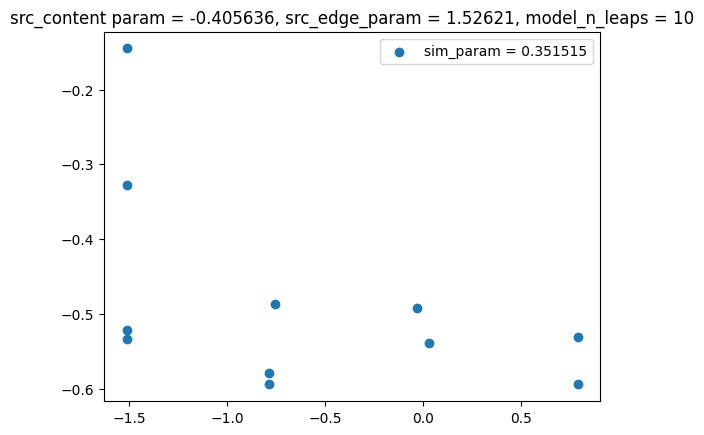

In [13]:
model.update_node_module.n_leaps = 10
### varying only x attentional bias 

for src_content_param in [-0.405636]:
    next(iter(model.update_node_module.lin_src_content.parameters())).data.fill_(src_content_param)
    
    for src_edge_param in 1*np.array([1.52621]): # np.linspace(-1,1,100):
        next(iter(model.update_node_module.lin_src_edge.parameters())).data.fill_(src_edge_param)

        # only 1 tensor
        for sim_param in [0.351515]:
            next(iter(p for p in model.update_node_module.lin_edge.parameters())).data.fill_(sim_param)
    

            complete_train_mask = participant_graph.complete_train_mask
            y_pred = model.predict(node_attr= participant_graph.x, 
                                edge_index= participant_graph.edge_index,
                                edge_attr= participant_graph.edge_attr,
                                complete_train_mask = complete_train_mask)
            y_pred = y_pred.detach().numpy()[complete_train_mask]
            y_true = participant_graph.y.detach().numpy()[complete_train_mask]

            sorted_ids = np.argsort(y_true,axis=0).flatten()
            
            plt.scatter(y_true,y_pred,label=f"sim_param = {sim_param}")

        plt.title(f"src_content param = {src_content_param}, src_edge_param = {src_edge_param}, model_n_leaps = 10")
        plt.legend()
        plt.show()